# Data Preparation for Coach of the Year

In this notebook we will prepare a dataset for the Coach of The Year Prediction

#### Load Dependencies

In [28]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('..')
import warnings
warnings.filterwarnings("ignore")

from data_scripts import _store_data as sd
from pathlib import Path

sd.load_data(Path("../data"))

#### Load and Prepare Dataset to calculate the variables

This section prepares coach data for analysis:

- **Copy Dataset:** Create a copy of the coaches dataframe and add Season 11 data.  
- **Drop Unnecessary Columns:** Remove columns like post_losses, post_wins, lgID.  
- **Aggregate by Team:** Group data by team and year, summing relevant columns.  
- **Aggregate by Coach:** Group data by coach and year.  
- **Add Season 11 Data:** Include additional data from Season 11 to ensure completeness.
- **Sort Data:** Organize aggregated dataframes by team/year and coach/year.

In [29]:
coaches_df = sd.coaches_df.copy()

# Adding data from Season 11
coaches_year11_df = pd.read_csv("../basketballPlayoffs/Season_11/coaches.csv")

coaches_df = pd.concat([coaches_df, coaches_year11_df], ignore_index=True)

coaches_df.drop(columns=['post_losses', 'post_wins', 'lgID'], inplace=True)

cols_to_sum = coaches_df.columns[
    coaches_df.columns.get_loc("stint") + 1 :
]

merged_teams = (
    coaches_df
    .groupby(["tmID", "year"], as_index=False)[cols_to_sum]
    .sum()
)

merged_teams = merged_teams.sort_values(['tmID','year'])

merged_coaches = (
    coaches_df
    .groupby(["coachID", "year"], as_index=False)[cols_to_sum]
    .sum()
)

merged_coaches = merged_coaches.sort_values(['coachID','year'])


#### Calculate previous team and coach win rates

This section calculates win rates for teams and coaches from previous years:

- **Define Functions:** Create functions to compute win rates for teams and coaches over 1 and 2 years.  
- **Apply Shifts:** Use groupby shift to get data from previous seasons.  
- **Calculate Rates:** Compute win rates as won / (won + lost), handling missing values.

In [30]:
def calculate_prev_teams_win_rates(df, years=2):
    for years in [1, 2]:
        col_suffix = f"prev_team_{years}yr"
        
        shifted = df.groupby('tmID')[['won', 'lost']].shift(years)
        
        prev_wr = [
            0 if pd.isna(shifted.iloc[i]['won']) else
            shifted.iloc[i]['won'] / (shifted.iloc[i]['won'] + shifted.iloc[i]['lost'])
            for i in range(len(shifted))
        ]
        
        df[f'win_rate_{col_suffix}'] = pd.Series(prev_wr, index=df.index)
    return df


def calculate_prev_coach_win_rates(df, years=2):
    for years in [1, 2]:
        col_suffix = f"prev_coach_{years}yr"
        
        shifted = df.groupby('coachID')[['won', 'lost']].shift(years)
        
        prev_wr = [
            0 if pd.isna(shifted.iloc[i]['won']) else
            shifted.iloc[i]['won'] / (shifted.iloc[i]['won'] + shifted.iloc[i]['lost'])
            for i in range(len(shifted))
        ]
        
        df[f'win_rate_{col_suffix}'] = pd.Series(prev_wr, index=df.index)
    return df

merged_teams = calculate_prev_teams_win_rates(merged_teams, 2)

merged_coaches = calculate_prev_coach_win_rates(merged_coaches, 2)

#### Calculate team change of coach in the middle of the season percentage

This section computes the rate of coach changes for teams in previous seasons:

- **Define Function:** Create a function to calculate cumulative coach changes.  
- **Rename and Filter:** Rename stint to change and filter out certain values.  
- **Compute Cumulative:** Calculate cumulative sum of changes per team.  
- **Calculate Rate:** Compute change rate as cumulative changes divided by (year - 1).

In [31]:
def calculate_cumulative_changes(coaches_df):
    coaches_df = coaches_df.copy()
    coaches_df = coaches_df.rename(columns={"stint": "change"})
    coaches_df = coaches_df.sort_values(['tmID', 'year']).reset_index(drop=True)
    coaches_df = coaches_df[coaches_df['change'] != 2]
    coaches_df['cum_coach_changes'] = coaches_df.groupby('tmID')['change'].cumsum()
    coaches_df['cum_coach_changes_prev'] = coaches_df.groupby('tmID')['cum_coach_changes'].shift(1).fillna(0)
    coaches_df['change_rate_prev'] = coaches_df['cum_coach_changes_prev'] / (coaches_df['year'] - 1)
    coaches_df['change_rate_prev'] = coaches_df['change_rate_prev'].fillna(0)
    coaches_df.drop(columns=['cum_coach_changes_prev', 'cum_coach_changes'], inplace=True)
    return coaches_df

team_coach_changes = calculate_cumulative_changes(coaches_df)

#### Calculate coach tenure

This section determines how long each coach has been with their team:

- **Define Function:** Create a function to calculate tenure based on consecutive years.  
- **Iterate and Set:** Loop through the dataframe to set tenure incrementally for same coach in consecutive years.

In [32]:
def calculate_tenure(df):
    df = df.sort_values("year").reset_index(drop=True)
    df["coach_tenure"] = 0
    
    for i in range(1, len(df)):
        same_coach = df.loc[i, "coachID"] == df.loc[i-1, "coachID"]
        same_year_consecutive = df.loc[i, "year"] == df.loc[i-1, "year"] + 1
        
        if same_coach and same_year_consecutive:
            df.loc[i, "coach_tenure"] = df.loc[i-1, "coach_tenure"] + 1
        else:
            df.loc[i, "coach_tenure"] = 0
    
    return df

coaches_df = (
    coaches_df
    .groupby(["tmID"], group_keys=False)
    .apply(calculate_tenure)
    .reset_index(drop=True)
)


#### Merge the datasets to get all the columns in one dataset

This section combines all prepared data into a single dataframe:

- **Merge Teams Data:** Combine merged_teams with coaches_df on tmID and year.  
- **Merge Coaches Data:** Add merged_coaches on coachID and year.  
- **Merge Changes:** Include team_coach_changes on tmID, year, coachID.  
- **Filter Stint:** Filter by stint values.

In [33]:
coaches_df = (
    merged_teams
    .merge(coaches_df, on=['tmID', 'year'], how='left')
    .merge(merged_coaches[['coachID', 'year', 'win_rate_prev_coach_1yr', 'win_rate_prev_coach_2yr']],
           on=['coachID', 'year'], how='left', suffixes=('', '_coach'))
)

coaches_df = (
    coaches_df
    .merge(team_coach_changes[["tmID", "year", "coachID", "change_rate_prev"]], on=["tmID", 'year', 'coachID'], how='left')
)

coaches_df = coaches_df[(coaches_df['stint'] == 0) | (coaches_df['stint'] == 1)]

coaches_df.drop(columns=['won_x', 'won_y', 'lost_x',  'lost_y', 'stint'], inplace=True)

#### Merge Coach of The Year Award Information

This section adds the Coach of the Year award data:

- **Filter Awards:** Select 'coach of the year' awards.  
- **Add Indicator:** Create a binary column for the award.  
- **Merge Data:** Combine with coaches_df on coachID and year.

In [34]:
coach_of_the_year_aw = sd.awards_players_df[sd.awards_players_df['award'].str.strip().str.lower() == 'coach of the year'].copy()
coach_of_the_year_aw['coach_of_the_year'] = 1

coaches_df = coaches_df.merge(
    coach_of_the_year_aw[['playerID', 'year', 'coach_of_the_year']],
    left_on=['coachID', 'year'],
    right_on=['playerID', 'year'],
    how='left'
)

coaches_df['coach_of_the_year'] = coaches_df['coach_of_the_year'].fillna(0).astype(int)

#### Order the DataSet and Save CSV

This section finalizes the dataset for modeling:

- **Define Order:** Specify desired column order.  
- **Select Columns:** Choose available columns in that order.  
- **Save to CSV:** Export the dataframe to coty.csv.

In [35]:
desired_order = [
    'coachID', 
    'year', 
    'tmID', 
    'coach_tenure', 
    'win_rate_prev_team_1yr', 
    'win_rate_prev_team_2yr', 
    'win_rate_prev_coach_1yr', 
    'win_rate_prev_coach_2yr', 
    'change_rate_prev', 
    'coach_of_the_year'
]

final_columns = [col for col in desired_order if col in coaches_df.columns]

coaches_df = coaches_df[final_columns]

coaches_df.to_csv("../predict_datasets/coty.csv", index=False)

#### Idea For the Dataset Preparation

Since this is the Coach of the Year dataset, we included the team’s and coach’s win rates from the previous season. These statistics help indicate how well the coach and the team were performing leading into the current season.

We also calculated the percentage of in season coaching changes each team has historically made in the WNBA. This helps assess whether a team typically trusts its coaches through the entire season, because if a coach is replaced mid season, they are very unlikely to win the award.

Additionally, through our analysis, we observed that a coach’s tenure with the team, specifically, having multiple years of experience with the same organization—serves as a useful indicator of whether they are likely to win the award.

#### Data Correlation Analysis

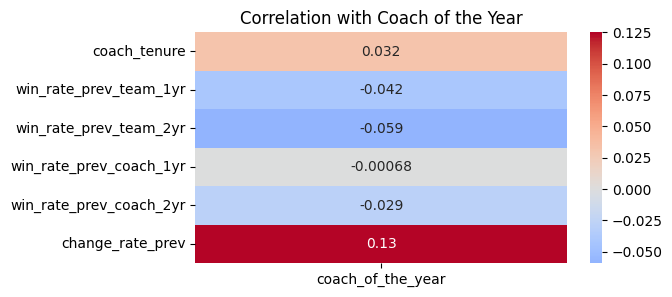

In [36]:
score_cols = ['coach_tenure', 'win_rate_prev_team_1yr', 'win_rate_prev_team_2yr', 'win_rate_prev_coach_1yr', 'win_rate_prev_coach_2yr', 'change_rate_prev', 'coach_of_the_year']
df_scores = coaches_df[score_cols]

corr_matrix = df_scores.corr()[['coach_of_the_year']]

corr_matrix = corr_matrix.drop('coach_of_the_year')

plt.figure(figsize=(6, len(corr_matrix)/2))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation with Coach of the Year")
plt.show()